In [1]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.stats import chisquare
from wordcloud import WordCloud

import numpy as np
import seaborn as sns

In [2]:
# create generic path using so that the code can run in both windows and linux systems
raw_data_path = os.path.abspath(os.path.join(os.getcwd(),os.path.pardir,'data','raw'))
processed_data_path = os.path.abspath(os.path.join(os.getcwd(),os.path.pardir,'data','processed'))
interim_data_path = os.path.abspath(os.path.join(os.getcwd(),os.path.pardir,'data','interim'))
print(raw_data_path)
print(processed_data_path)
print(interim_data_path)

G:\Git Projects\twitter_product_sentiment\data\raw
G:\Git Projects\twitter_product_sentiment\data\processed
G:\Git Projects\twitter_product_sentiment\data\interim


In [3]:
# read data
df = pd.read_csv(os.path.abspath(os.path.join(raw_data_path,'train.csv')))

In [4]:
def create_base_df(df):
    df.dropna(inplace=True)
    # checking if tweet is blank
    df['isblank']=df.tweet.apply(lambda x: 0 if len(x.strip())>0 else 1 )
    # charcount
    df['charcount']=df.tweet.apply(lambda x: len(x.replace(" ",'')))
    df['countwords'] = df.tweet.apply(lambda x: count_regex(r'\w+',x))
    df['@counts'] = df.tweet.apply(lambda x: count_regex(r'@\w+',x))
    df['#counts'] = df.tweet.apply(lambda x: count_regex(r'#\w+',x))
    df['Capscounts'] = df.tweet.apply(lambda x: count_regex(r'\b[A-Z]{2,}\b',x))
    df['count_excl_quest_marks'] = df.tweet.apply(lambda x: count_regex(r'!|\?',x))
    df['count_urls '] = df.tweet.apply(lambda x: count_regex(r'http.?://[^\s]+[\s]?',x))
    df['count_special_chars'] = df.tweet.apply(lambda x: count_regex('\W',x.replace(" ",'')))
    df.drop(['isblank'],inplace=True,axis=1)
    col_list = ['charcount', 'countwords', '@counts','#counts', 'Capscounts', 'count_excl_quest_marks', 'count_urls ','count_special_chars']
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    len(stop_words)
    required_words = ['was', 'did', 'but', 'against', 'not', 'no' , 'nor', 'over', 'under', 'again', 'few', 'more', 'most', 'too', 'very', 'couldn',
    'couldn\'t', 'don\'t','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",
    'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",
    'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
    stop_words = [i for i in stop_words if i not in required_words]
    companies = pd.read_csv(os.path.abspath(os.path.join(raw_data_path,'companies.csv')))
    companies['Company']=companies['Company'].apply(lambda x: x.lower())
    companies_list = list(companies['Company'])
    without_stopwords = df.tweet.apply(lambda x: common_words_counter(' '.join([i for i in x.split() if i.lower() not in stop_words]),5))
    bins = without_stopwords.apply(lambda x: get_bins(x))
    df['Company'] = bins
    df_final = pd.merge(df, companies, on='Company',how='left')
    unique_companies = ['apple', 'lear', 'other', 'amp', 'google', 'ca', 'oi', 'iss','sse', 'facebook', 'eni', 'paypal', 'next', 'accor', 'ses', 'tui','nec', 'itc', 'ppl', 'total', 'microsoft', 'sca', 'map', 'sap','netflix', 'hilton', 'pvh', 'abb', 'ball', 'sony', 'pepsico', 'hp','eads', 'bp', 'scor', 'vmware', 'snap', 'ubs', 'cbs', 'smc','williams', 'fedex', 'gap', 'popular', 'ccr', 'anz', 'starbucks','terna', 'orange', 'intel']
    return df

In [5]:
df.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7274 non-null int64
tweet        7273 non-null object
sentiment    7274 non-null int64
dtypes: int64(2), object(1)
memory usage: 170.6+ KB


In [7]:
df.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
dtype: int64

**Insights:**
There is one row with null as tweet. Which can be removed

In [8]:
# droping na
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7273 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7273 non-null int64
tweet        7273 non-null object
sentiment    7273 non-null int64
dtypes: int64(2), object(1)
memory usage: 227.3+ KB


In [9]:
# checking if tweet is blank
df['isblank']=df.tweet.apply(lambda x: 0 if len(x.strip())>0 else 1 )

In [10]:
df.isblank.value_counts()

0    7273
Name: isblank, dtype: int64

**Insigts:** No blank tweets found

In [11]:
df.head()

,tweet_id,tweet,sentiment,isblank
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,0
1,1851,Learning ab Google doodles! All doodles should...,1,0
2,2689,one of the most in-your-face ex. of stealing t...,2,0
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,0
4,3604,Line outside the Apple store in Austin waiting...,1,0


In [12]:
# charcount
df['charcount']=df.tweet.apply(lambda x: len(x.replace(" ",'')))

In [13]:
df.charcount.min()

10

sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

In [14]:
df_Negative = df[df['sentiment']==0]
df_Neutral = df[df['sentiment']==1]
df_Positive = df[df['sentiment']==2]
df_Unknown = df[df['sentiment']==3]

In [15]:
df_Negative['sentiment'].head()

3     0
24    0
34    0
50    0
63    0
Name: sentiment, dtype: int64

In [16]:
text_Negative = ' '.join(df_Negative['tweet'])
text_Neutral = ' '.join(df_Neutral['tweet'])
text_Positive = ' '.join(df_Positive['tweet'])
text_Unknown = ' '.join(df_Unknown['tweet'])

In [17]:
word = '@mention'
wordlen = len(text_Negative.split())
count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text_Negative))
print('text_Negative has {} and {}%  @ mention'.format(count,(count/wordlen)*100))
wordlen = len(text_Neutral.split())
count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text_Neutral))
print('text_Neutral has {} and {}%  @ mention'.format(count,(count/wordlen)*100))
wordlen = len(text_Positive.split())
count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text_Positive))
print('text_Positive has {} and {}%  @mention'.format(count,(count/wordlen)*100))
wordlen = len(text_Unknown.split())
count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text_Unknown))
print('text_Unknown has {} and {}%  @mention'.format(count,(count/wordlen)*100))

text_Negative has 8 and 0.09389671361502347%  @ mention
text_Neutral has 104 and 0.13878880081138067%  @ mention
text_Positive has 61 and 0.1405465185936132%  @mention
text_Unknown has 2 and 0.09149130832570906%  @mention


In [18]:
def count_regex(pattern, tweet):
    return len(re.findall(pattern, tweet))

In [19]:
df['countwords'] = df.tweet.apply(lambda x: count_regex(r'\w+',x))
df['@counts'] = df.tweet.apply(lambda x: count_regex(r'@\w+',x))
df['#counts'] = df.tweet.apply(lambda x: count_regex(r'#\w+',x))
df['Capscounts'] = df.tweet.apply(lambda x: count_regex(r'\b[A-Z]{2,}\b',x))
df['count_excl_quest_marks'] = df.tweet.apply(lambda x: count_regex(r'!|\?',x))
df['count_urls '] = df.tweet.apply(lambda x: count_regex(r'http.?://[^\s]+[\s]?',x))
df['count_special_chars'] = df.tweet.apply(lambda x: count_regex('\W',x.replace(" ",'')))

In [20]:
df.drop(['isblank'],inplace=True,axis=1)
df.head()

,tweet_id,tweet,sentiment,charcount,countwords,@counts,#counts,Capscounts,count_excl_quest_marks,count_urls,count_special_chars
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,78,12,0,3,0,0,0,3
1,1851,Learning ab Google doodles! All doodles should...,1,125,19,0,2,0,1,0,8
2,2689,one of the most in-your-face ex. of stealing t...,2,110,26,1,1,2,0,0,12
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,107,20,0,3,1,0,0,5
4,3604,Line outside the Apple store in Austin waiting...,1,63,14,0,1,1,0,0,3


In [21]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', height=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for charcount
-------------------------------
            count       mean        std   min    25%   50%    75%    max
sentiment                                                               
0           456.0  91.105263  23.265545  32.0  75.75  95.5  110.0  135.0
1          4310.0  87.473782  22.798616  10.0  72.00  91.0  105.0  165.0
2          2382.0  88.468094  22.847642  22.0  72.25  92.0  106.0  146.0
3           125.0  85.112000  23.162545  34.0  67.00  85.0  104.0  128.0


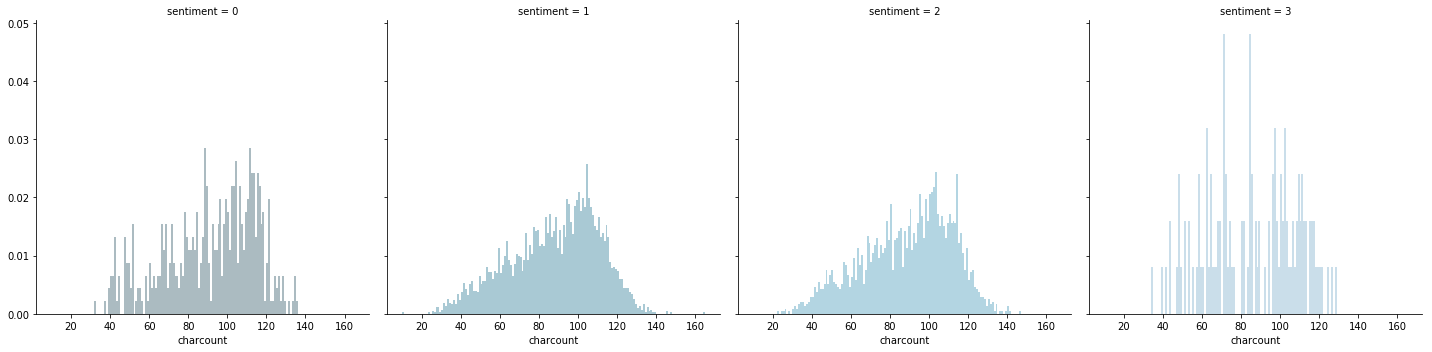

Descriptive stats for countwords
--------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0           456.0  19.500000  5.405736  6.0  16.0  20.0  24.0  32.0
1          4310.0  18.045012  5.223198  2.0  14.0  18.0  22.0  41.0
2          2382.0  18.863980  5.289912  4.0  15.0  19.0  23.0  35.0
3           125.0  18.152000  5.296158  8.0  14.0  18.0  22.0  30.0


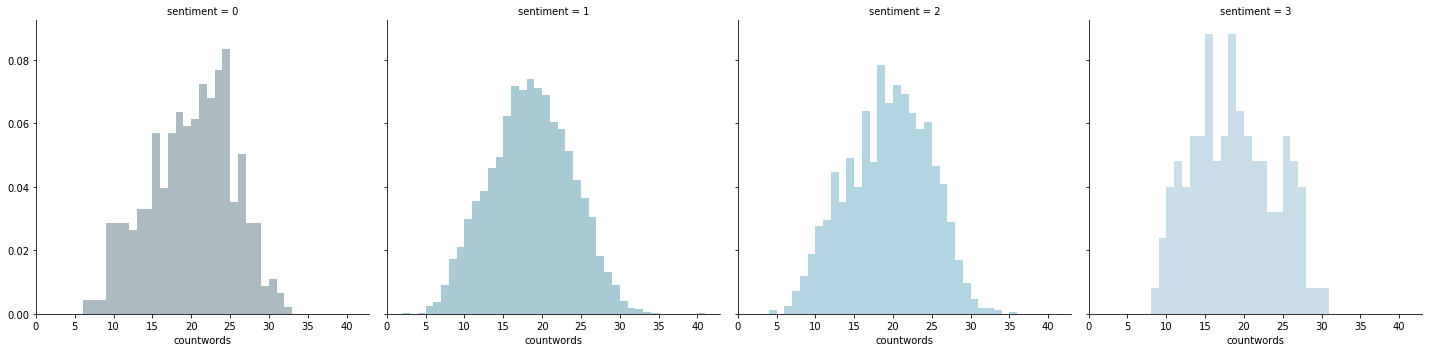

Descriptive stats for @counts
-----------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0           456.0  0.552632  0.739374  0.0  0.0  0.0  1.0  4.0
1          4310.0  0.850348  0.976455  0.0  0.0  1.0  1.0  8.0
2          2382.0  0.740134  0.838025  0.0  0.0  1.0  1.0  5.0
3           125.0  0.640000  0.962188  0.0  0.0  0.0  1.0  5.0


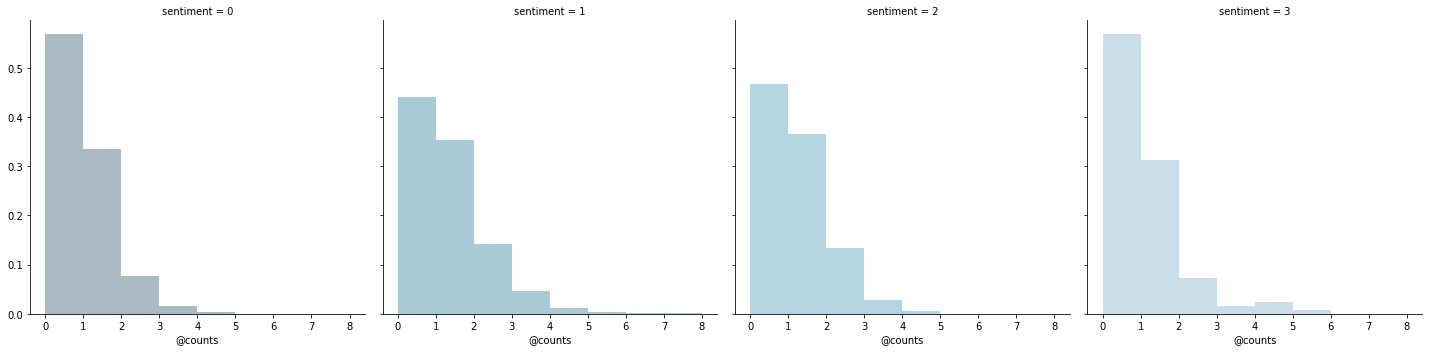

Descriptive stats for #counts
-----------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0           456.0  1.605263  0.839868  1.0  1.0  1.0  2.0   6.0
1          4310.0  1.792575  1.180463  0.0  1.0  1.0  2.0  12.0
2          2382.0  1.683039  0.952835  0.0  1.0  1.0  2.0   7.0
3           125.0  1.600000  0.950382  1.0  1.0  1.0  2.0   5.0


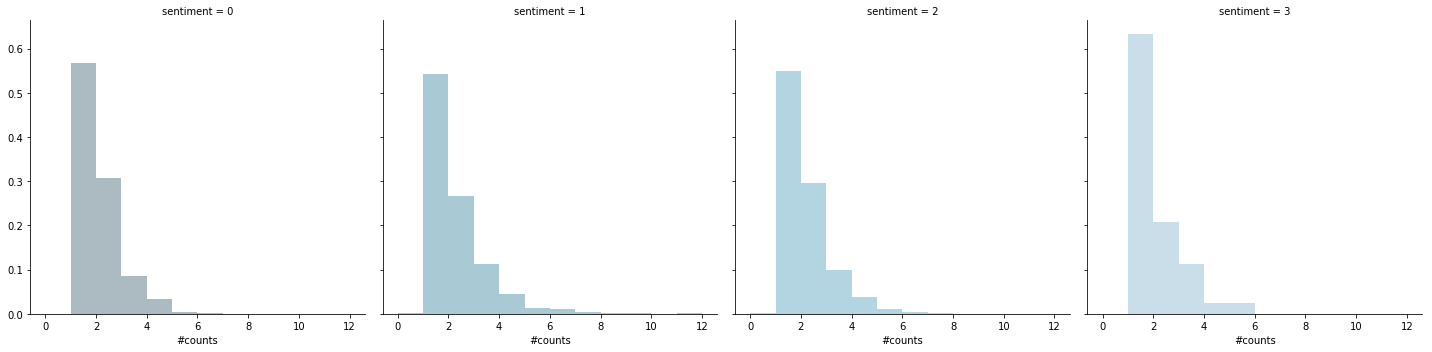

Descriptive stats for Capscounts
--------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0           456.0  0.901316  1.199413  0.0  0.0  1.0  1.0  18.0
1          4310.0  1.110209  1.060554  0.0  0.0  1.0  2.0  17.0
2          2382.0  1.033165  0.963940  0.0  0.0  1.0  2.0   6.0
3           125.0  0.976000  0.919888  0.0  0.0  1.0  1.0   4.0


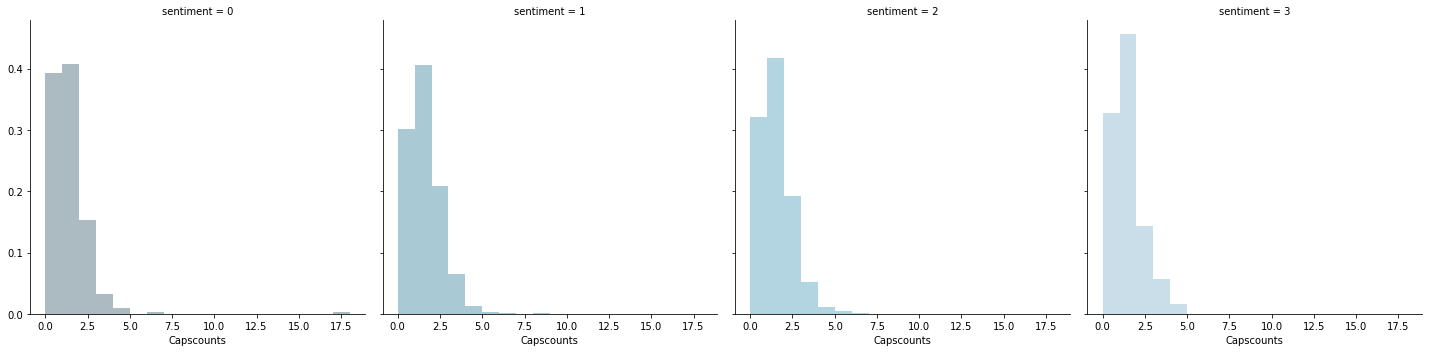

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0           456.0  0.361842  0.819134  0.0  0.0  0.0  0.0   8.0
1          4310.0  0.406265  0.767710  0.0  0.0  0.0  1.0  11.0
2          2382.0  0.548699  0.903084  0.0  0.0  0.0  1.0   9.0
3           125.0  0.424000  0.825638  0.0  0.0  0.0  1.0   3.0


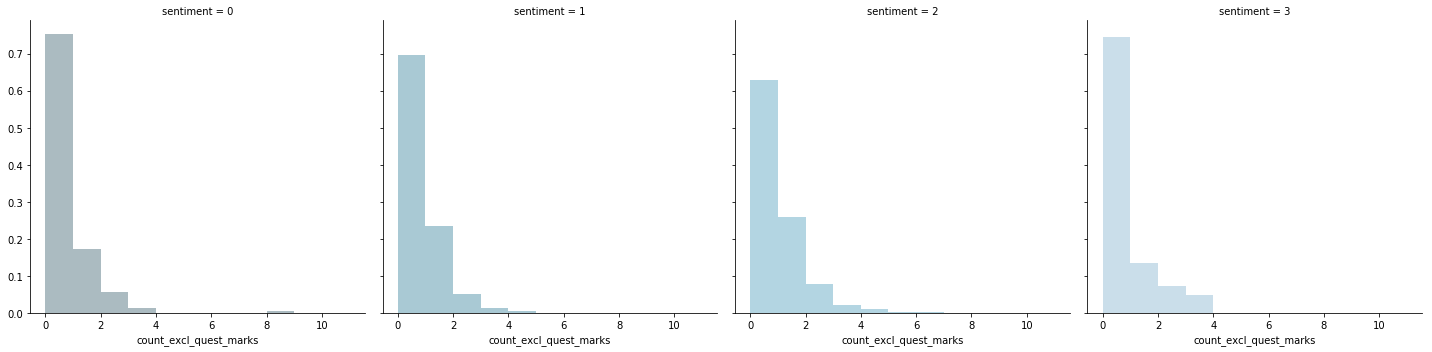

Descriptive stats for count_urls 
---------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0           456.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4310.0  0.001624  0.040272  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.004618  0.067813  0.0  0.0  0.0  0.0  1.0
3           125.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


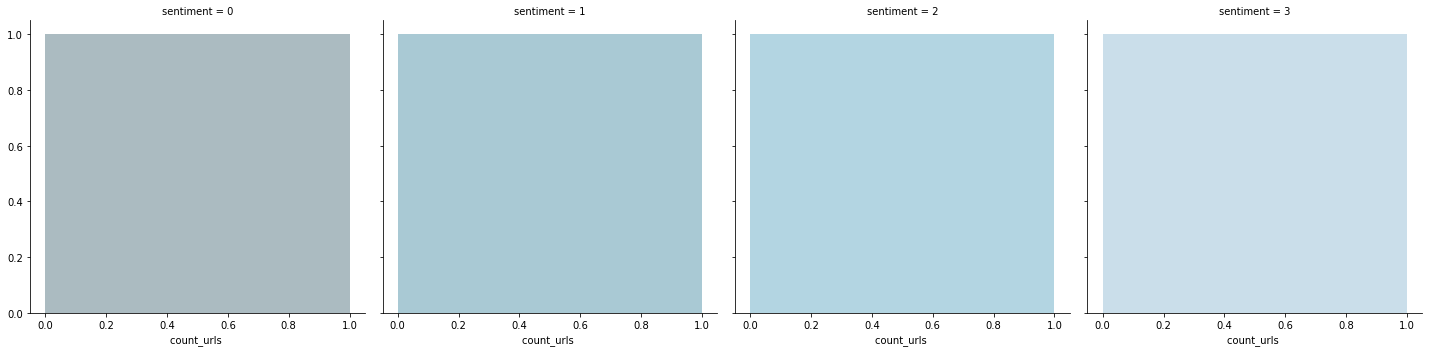

Descriptive stats for count_special_chars
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0           456.0  6.401316  3.102484  1.0  4.0  6.0  8.0  24.0
1          4310.0  7.452900  3.482607  1.0  5.0  7.0  9.0  66.0
2          2382.0  7.060873  3.067912  1.0  5.0  7.0  9.0  21.0
3           125.0  6.336000  3.323776  1.0  4.0  5.0  8.0  17.0


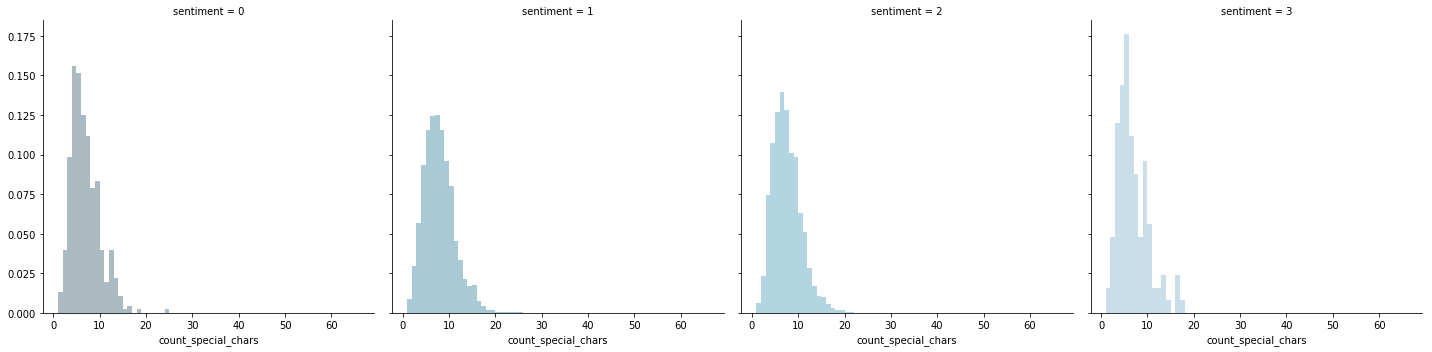

In [22]:
col_list = ['charcount', 'countwords', '@counts','#counts', 'Capscounts', 'count_excl_quest_marks', 'count_urls ','count_special_chars']
for i in col_list:
    show_dist(df,i)

In [23]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None

        self.dfObserved = None
        self.dfExpected = None

    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)

    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)

        self.dfObserved = pd.crosstab(Y,X)
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof

        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)

        self._print_chisquare_result(colX,alpha)

In [24]:
c1 = ChiSquare(df)

In [25]:
col_list = ['charcount', 'countwords','@counts','#counts', 'Capscounts', 'count_excl_quest_marks', 'count_urls ','count_special_chars']
for i in col_list:
    c1.TestIndependence(i,'sentiment')

charcount is NOT an important predictor. (Discard charcount from model)
countwords is IMPORTANT for Prediction
@counts is IMPORTANT for Prediction
#counts is IMPORTANT for Prediction
Capscounts is IMPORTANT for Prediction
count_excl_quest_marks is IMPORTANT for Prediction
count_urls  is NOT an important predictor. (Discard count_urls  from model)
count_special_chars is IMPORTANT for Prediction


In [26]:
# get most common words in training dataset
from collections import Counter

def common_words_counter(series_tweet,n=4):
     #split() returns list of all the words in the string
    split_it = series_tweet.split()

    # Pass the split_it list to instance of Counter class.
    Counter1 = Counter(split_it)
    #print(Counter)

    # most_common() produces k frequently encountered
    # input values and their respective counts.
    most_occur = Counter1.most_common(n)
    return most_occur

In [27]:
df.tweet[703]

'Free iTunes SXSW &quot;Featured Artists&quot; sampler: {link} #free #music #SXSW'

In [28]:
print('frequent words in text_negative\n',common_words_counter(text_Negative))
print('\nfrequent words in text_Neutral\n',common_words_counter(text_Neutral))
print('\nfrequent words in text_Positive\n',common_words_counter(text_Positive))
print('\nfrequent words in text_Unknown\n',common_words_counter(text_Unknown))

frequent words in text_negative
 [('#sxsw', 243), ('@mention', 233), ('the', 221), ('to', 196)]

frequent words in text_Neutral
 [('@mention', 3409), ('{link}', 2339), ('#sxsw', 1922), ('#SXSW', 1755)]

frequent words in text_Positive
 [('@mention', 1648), ('the', 1150), ('#sxsw', 1019), ('{link}', 950)]

frequent words in text_Unknown
 [('@mention', 76), ('#SXSW', 53), ('#sxsw', 52), ('the', 49)]


In [29]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
len(stop_words)

179

In [30]:
required_words = ['was', 'did', 'but', 'against', 'not', 'no' , 'nor', 'over', 'under', 'again', 'few', 'more', 'most', 'too', 'very', 'couldn',
'couldn\'t', 'don\'t','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",
'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",
'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
stop_words = [i for i in stop_words if i not in required_words]


In [31]:
len(stop_words)

127

In [32]:
# load companies
companies = pd.read_csv(os.path.abspath(os.path.join(raw_data_path,'companies.csv')))
companies.head()

,Company,Country
0,ICBC,China
1,China Construction Bank,China
2,Berkshire Hathaway,United States
3,JPMorgan Chase,United States
4,Wells Fargo,United States


In [33]:
companies['Company']=companies['Company'].apply(lambda x: x.lower())

In [34]:
companies_list = list(companies['Company'])

In [35]:

without_stopwords = df.tweet.apply(lambda x: common_words_counter(' '.join([i for i in x.split() if i.lower() not in stop_words]),5))

In [36]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [37]:
def get_bins(list1):
    for i in list1:
        if(i[0].lower() in companies_list):
            return i[0].lower()
        for j in companies_list: 
            txt = i[0].lower()
            if(txt.find(j.lower())!=-1):
                return j.lower()
    return 'other'



In [38]:
without_stopwords.head()

0    [(#sxswnui, 1), (#sxsw, 1), (#apple, 1), (defi...
1    [(Learning, 1), (ab, 1), (Google, 1), (doodles...
2    [(one, 1), (most, 1), (in-your-face, 1), (ex.,...
3    [(iPhone, 1), (#SXSW, 1), (app, 1), (would, 1)...
4    [(Line, 1), (outside, 1), (Apple, 1), (store, ...
Name: tweet, dtype: object

In [39]:
bins = without_stopwords.apply(lambda x: get_bins(x))

In [40]:
df['Company'] = bins

In [41]:
df_final = pd.merge(df, companies, on='Company',how='left')

In [42]:
df_final.head()

,tweet_id,tweet,sentiment,charcount,countwords,@counts,#counts,Capscounts,count_excl_quest_marks,count_urls,count_special_chars,Company,Country
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,78,12,0,3,0,0,0,3,apple,United States
1,1851,Learning ab Google doodles! All doodles should...,1,125,19,0,2,0,1,0,8,lear,United States
2,2689,one of the most in-your-face ex. of stealing t...,2,110,26,1,1,2,0,0,12,other,NaN
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,107,20,0,3,1,0,0,5,other,NaN
4,3604,Line outside the Apple store in Austin waiting...,1,63,14,0,1,1,0,0,3,apple,United States


In [43]:
df.Company.unique()

array(['apple', 'lear', 'other', 'amp', 'google', 'ca', 'oi', 'iss',
       'sse', 'facebook', 'eni', 'paypal', 'next', 'accor', 'ses', 'tui',
       'nec', 'itc', 'ppl', 'total', 'microsoft', 'sca', 'map', 'sap',
       'netflix', 'hilton', 'pvh', 'abb', 'ball', 'sony', 'pepsico', 'hp',
       'eads', 'bp', 'scor', 'vmware', 'snap', 'ubs', 'cbs', 'smc',
       'williams', 'fedex', 'gap', 'popular', 'ccr', 'anz', 'starbucks',
       'terna', 'orange', 'intel'], dtype=object)

In [44]:
unique_companies = ['apple', 'lear', 'other', 'amp', 'google', 'ca', 'oi', 'iss','sse', 'facebook', 'eni', 'paypal', 'next', 'accor', 'ses', 'tui','nec', 'itc', 'ppl', 'total', 'microsoft', 'sca', 'map', 'sap','netflix', 'hilton', 'pvh', 'abb', 'ball', 'sony', 'pepsico', 'hp','eads', 'bp', 'scor', 'vmware', 'snap', 'ubs', 'cbs', 'smc','williams', 'fedex', 'gap', 'popular', 'ccr', 'anz', 'starbucks','terna', 'orange', 'intel']

In [45]:
def plot_bar_graph(df1,col):
    print(col)
    print(len(df1[df1['Company']==col]))
    df1[df1['Company']==col]['sentiment'].value_counts().plot(kind='bar')
    plt.show()

apple
1041


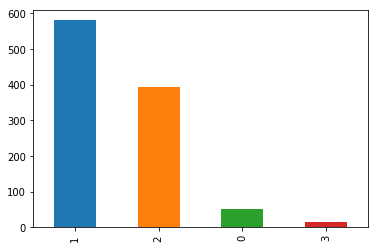

lear
24


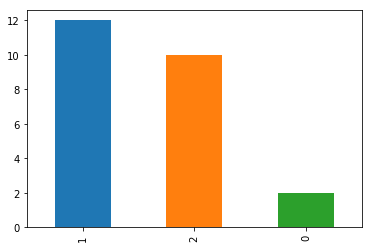

other
3831


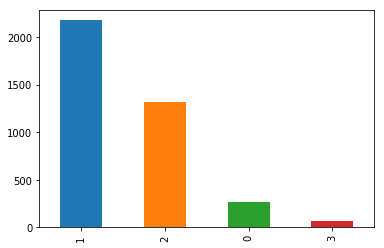

amp
171


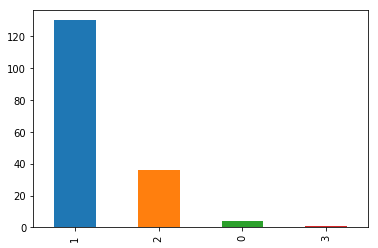

google
1185


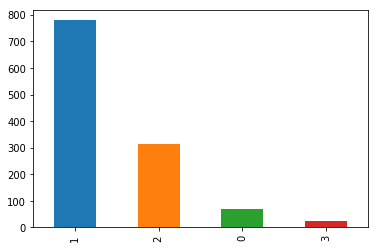

ca
264


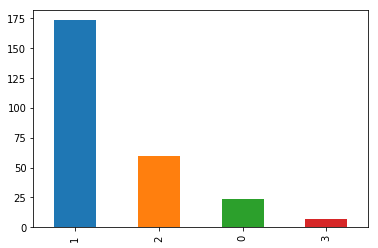

oi
298


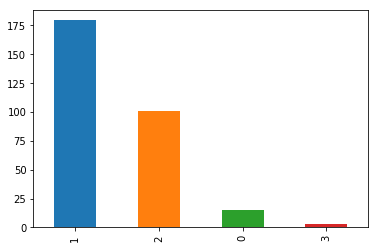

iss
103


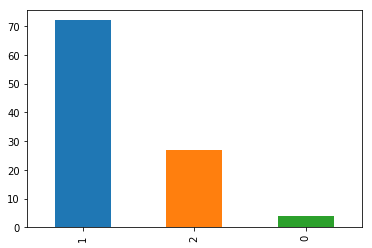

sse
33


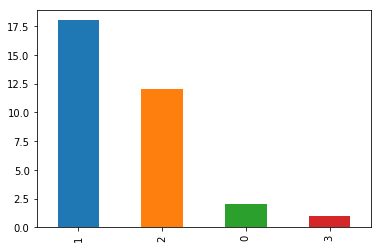

facebook
13


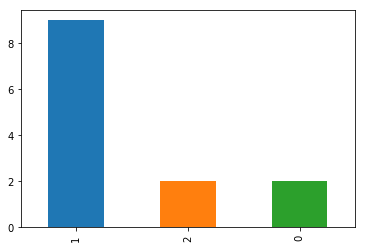

eni
39


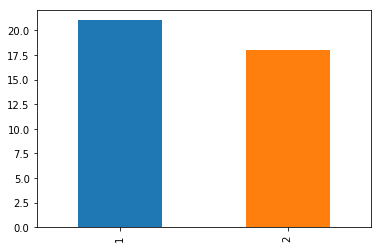

paypal
1


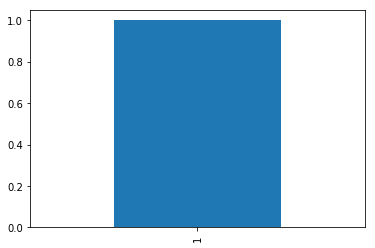

next
47


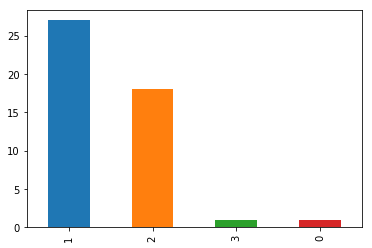

accor
4


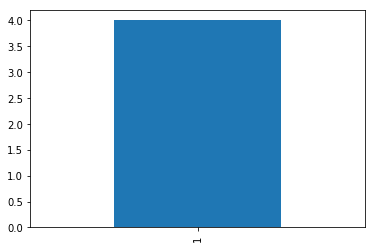

ses
58


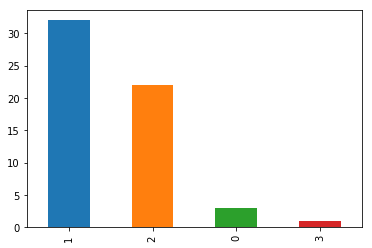

tui
1


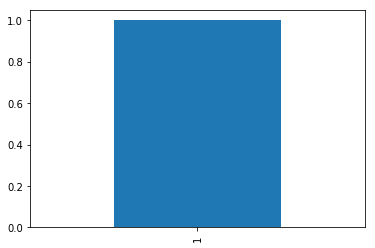

nec
7


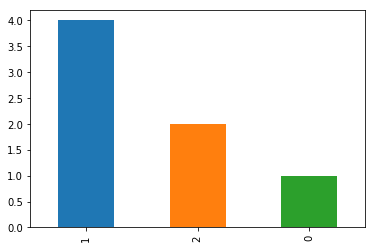

itc
6


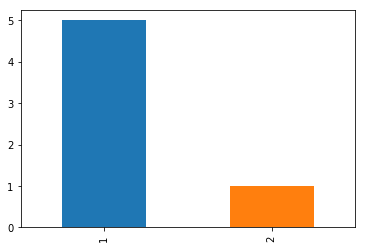

ppl
16


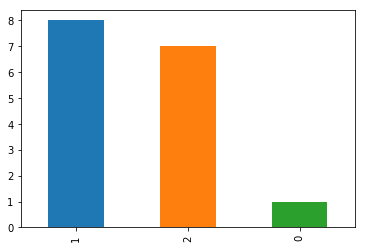

total
10


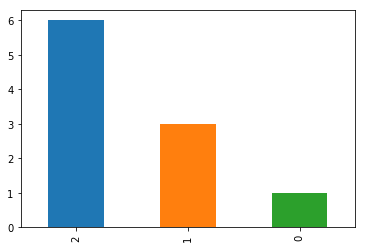

microsoft
5


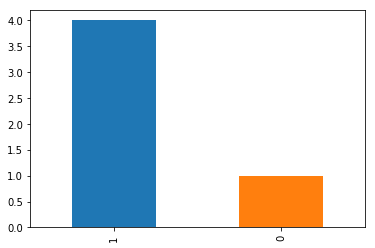

sca
9


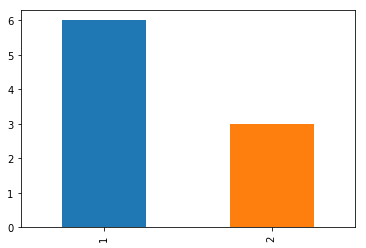

map
18


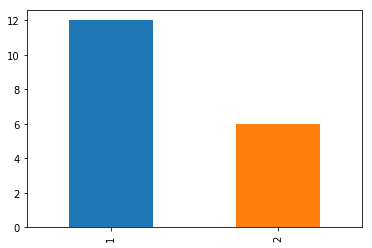

sap
6


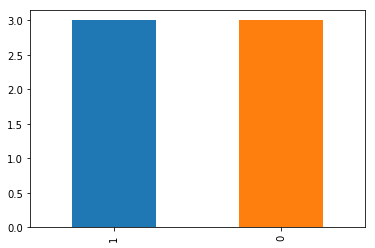

netflix
10


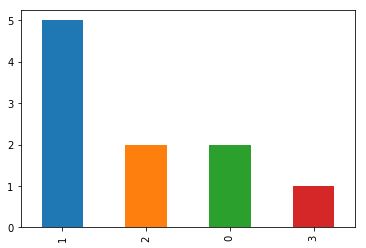

hilton
6


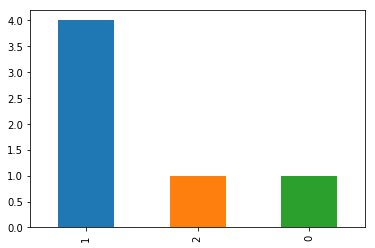

pvh
1


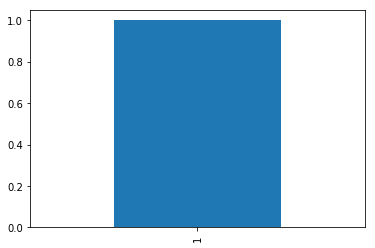

abb
4


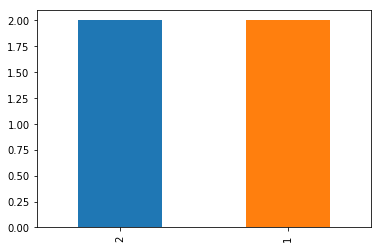

ball
8


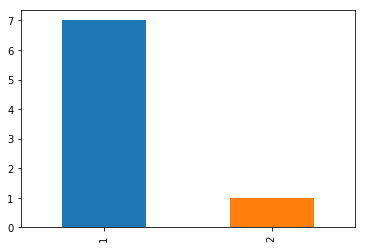

sony
8


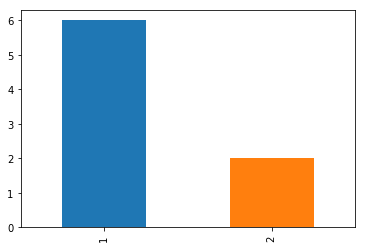

pepsico
4


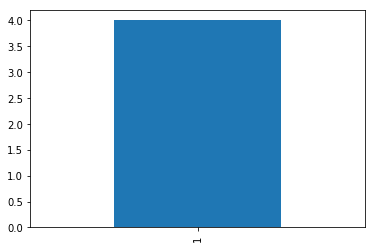

hp
2


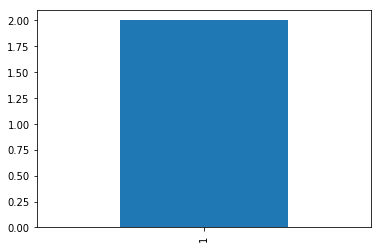

eads
3


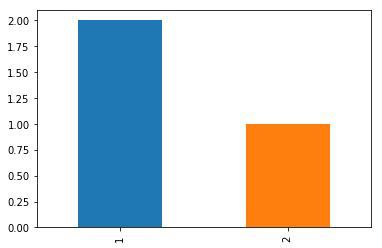

bp
1


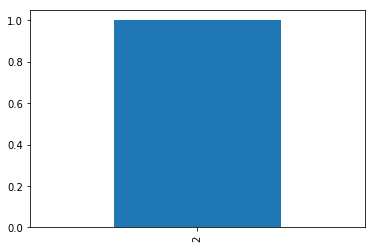

scor
9


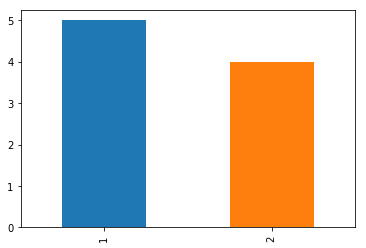

vmware
2


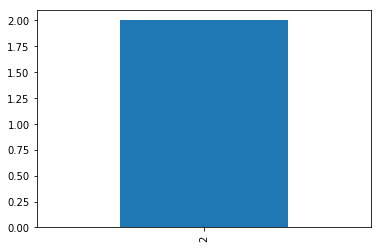

snap
2


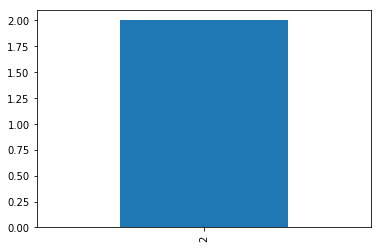

ubs
4


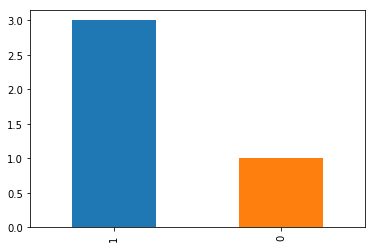

cbs
1


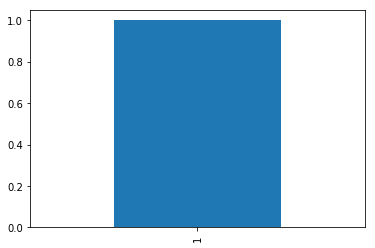

smc
2


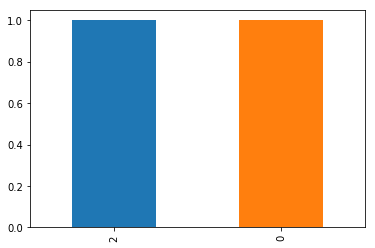

williams
1


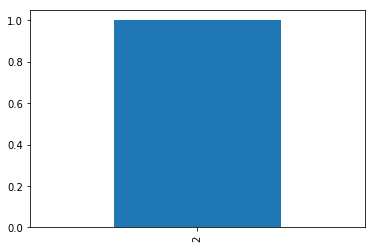

fedex
3


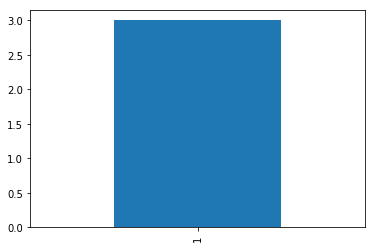

gap
3


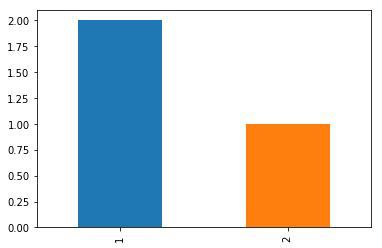

popular
3


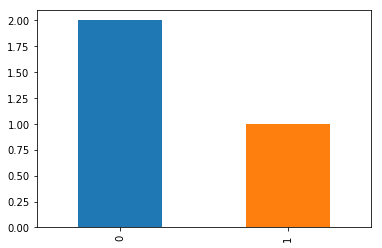

ccr
1


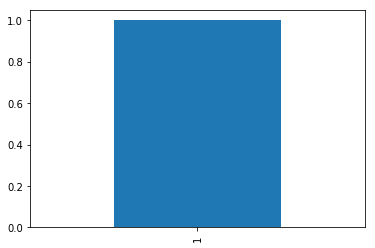

anz
1


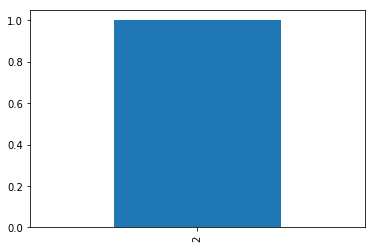

starbucks
1


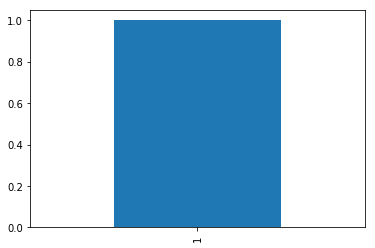

terna
1


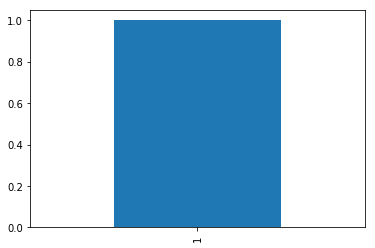

orange
1


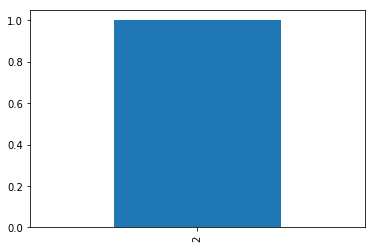

intel
1


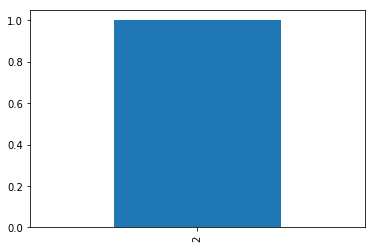

In [46]:
for i in unique_companies:
    plot_bar_graph(df,i)

sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

In [47]:
df.to_csv(os.path.abspath(os.path.join(interim_data_path,'train.csv')))

In [48]:
# read data
df = pd.read_csv(os.path.abspath(os.path.join(raw_data_path,'test.csv')))

In [49]:
base_df = create_base_df(df)

In [50]:
base_df.to_csv(os.path.abspath(os.path.join(interim_data_path,'test.csv')))